In [1]:
### https://towardsdatascience.com/cryptocurrency-price-prediction-using-deep-learning-70cfca50dd3a

In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [2]:
# run only 1 of these cells

# sea temperature
hist= pd.read_csv('https://erddap.marine.ie/erddap/tabledap/IWBNetwork.csv?station_id%2Ctime%2CSeaTemperature&station_id=%22M4%22&time%3E=2021-04-01T00%3A00%3A00Z&time%3C=2022-03-31T00%3A00%3A00Z',index_col=[0],header=[0],skiprows=[1],parse_dates=True,infer_datetime_format=True)

# https://erddap.marine.ie/erddap/tabledap/IWBNetwork.csv?station_id%2Ctime%2CAtmosphericPressure%2CWindDirection%2CWindSpeed%2CAirTemperature%2CDewPoint%2CSeaTemperature%2Csalinity%2CRelativeHumidity&station_id=%22M4%22&time%3E=2021-12-01T00%3A00%3A00Z&time%3C=2022-01-31T00%3A00%3A00Z

# endpoint = 'https://erddap.marine.ie/erddap/tabledap/'
# res = requests.get(endpoint + 'IWBNetwork.json?station_id%2Ctime%2CAtmosphericPressure%2CWindDirection%2CWindSpeed%2CAirTemperature%2CDewPoint%2CSeaTemperature%2Csalinity%2CRelativeHumidity&station_id=%22M4%22&time%3E=2021-12-01T00%3A00%3A00Z&time%3C=2022-01-31T00%3A00%3A00Z')
# hist = pd.DataFrame(json.loads(res.content))
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='ns')
target_col = 'SeaTemperature'
    

# endpoint = 'https://min-api.cryptocompare.com/data/histoday'
# res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=500')
# hist = pd.DataFrame(json.loads(res.content)['Data'])
# hist = hist.set_index('time')
# hist.index = pd.to_datetime(hist.index, unit='s')
# target_col = 'close'

In [4]:
# wind speed
hist= pd.read_csv('https://erddap.marine.ie/erddap/tabledap/IWBNetwork.csv?station_id%2Ctime%2CWindSpeed&station_id=%22M4%22&time%3E=2021-12-01T00%3A00%3A00Z&time%3C=2022-01-31T00%3A00%3A00Z',index_col=[0],header=[0],skiprows=[1],parse_dates=True,infer_datetime_format=True)

# https://erddap.marine.ie/erddap/tabledap/IWBNetwork.csv?station_id%2Ctime%2CAtmosphericPressure%2CWindDirection%2CWindSpeed%2CAirTemperature%2CDewPoint%2CSeaTemperature%2Csalinity%2CRelativeHumidity&station_id=%22M4%22&time%3E=2021-12-01T00%3A00%3A00Z&time%3C=2022-01-31T00%3A00%3A00Z

# endpoint = 'https://erddap.marine.ie/erddap/tabledap/'
# res = requests.get(endpoint + 'IWBNetwork.json?station_id%2Ctime%2CAtmosphericPressure%2CWindDirection%2CWindSpeed%2CAirTemperature%2CDewPoint%2CSeaTemperature%2Csalinity%2CRelativeHumidity&station_id=%22M4%22&time%3E=2021-12-01T00%3A00%3A00Z&time%3C=2022-01-31T00%3A00%3A00Z')
# hist = pd.DataFrame(json.loads(res.content))
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='ns')
target_col = 'WindSpeed'

In [3]:
hist.head(5)

,SeaTemperature
time,
2021-04-01 00:00:00+00:00,9.955
2021-04-01 01:00:00+00:00,9.950
2021-04-01 02:00:00+00:00,9.950
2021-04-01 03:00:00+00:00,9.950
2021-04-01 04:00:00+00:00,9.944


In [4]:
def train_test_validate_split(df, validation_size=0.15, test_size=0.15):
    n_train = len(df) - int(test_size * len(df)) - int(validation_size * len(df))
    n_validate = int(validation_size * len(df))
    train_data = df.iloc[:n_train]
    validation_data = df.iloc[n_train:(n_train+n_validate)]        
    test_data = df.iloc[(n_train+n_validate):]
    return train_data, validation_data, test_data

In [5]:
train, validate, test = train_test_validate_split(hist, validation_size=0.15, test_size=0.15)

In [6]:
def line_plot(line1, line2, line3, 
              label1=None, label2=None, label3=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.plot(line3, label=label3, linewidth=lw)
    ax.set_ylabel('target', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

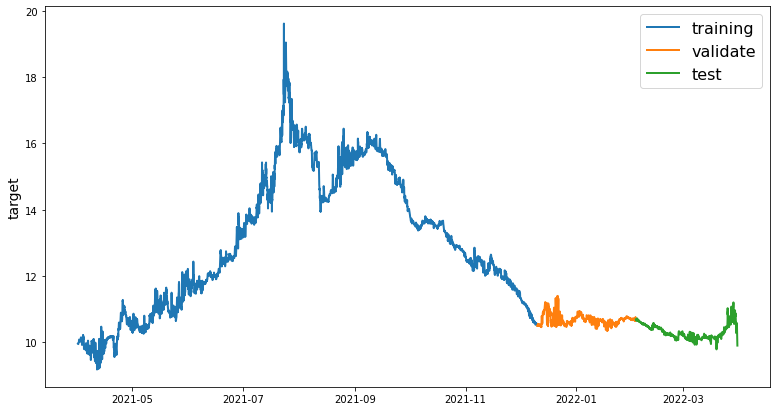

In [7]:
line_plot(train[target_col], validate[target_col], test[target_col], 'training', 'validate', 'test', title='')

In [8]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [9]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [10]:
def prepare_data(df, target_col, window_len=10, zero_base=True, validation_size=0.15, test_size=0.15):
    train_data, validation_data, test_data = train_test_validate_split(df, validation_size=validation_size, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_validate = extract_window_data(validation_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    
    y_train = train_data[target_col][window_len:].values
    y_validate = validation_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_validate, X_test, y_train, y_validate, y_test

In [11]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [12]:
np.random.seed(42)
window_len = 5
test_size = 0.15
zero_base = True
lstm_neurons = 100
epochs = 40
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [13]:
train, test, X_train, X_validate, X_test, y_train, y_validate, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=0.15)

In [14]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_validate, y_validate), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/40
190/190 [==============================] - 3s 6ms/step - loss: 9.1744e-05 - val_loss: 114.2173
Epoch 2/40
190/190 [==============================] - 1s 4ms/step - loss: 5.3935e-05 - val_loss: 114.1668
Epoch 3/40
190/190 [==============================] - 1s 4ms/step - loss: 4.6208e-05 - val_loss: 114.2162
Epoch 4/40
190/190 [==============================] - 1s 4ms/step - loss: 4.4927e-05 - val_loss: 114.1304
Epoch 5/40
190/190 [==============================] - 1s 4ms/step - loss: 4.4592e-05 - val_loss: 114.2264
Epoch 6/40
190/190 [==============================] - 1s 4ms/step - loss: 4.4589e-05 - val_loss: 114.1556
Epoch 7/40
190/190 [==============================] - 1s 4ms/step - loss: 4.5345e-05 - val_loss: 114.1574
Epoch 8/40
190/190 [==============================] - 1s 4ms/step - loss: 4.4557e-05 - val_loss: 114.2009
Epoch 9/40
190/190 [==============================] - 1s 4ms/step - loss: 4.3968e-05 - val_loss: 114.1950
Epoch 10/40
190/190 [=========================

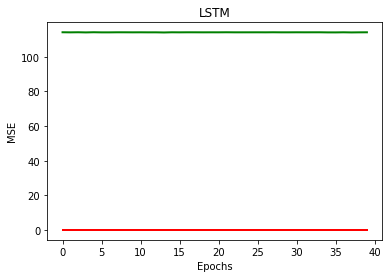

In [15]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [16]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
# unnormalize predictions
preds_test = (preds + 1) * test[target_col][0]
mean_absolute_error(preds, y_test)

0.0020754322938409953

In [17]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

1.3764322230439492e-05

In [18]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.8256328630356524

In [19]:
# targets = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds_test)
# line_plot(targets, preds, 'actual', 'prediction', lw=3)

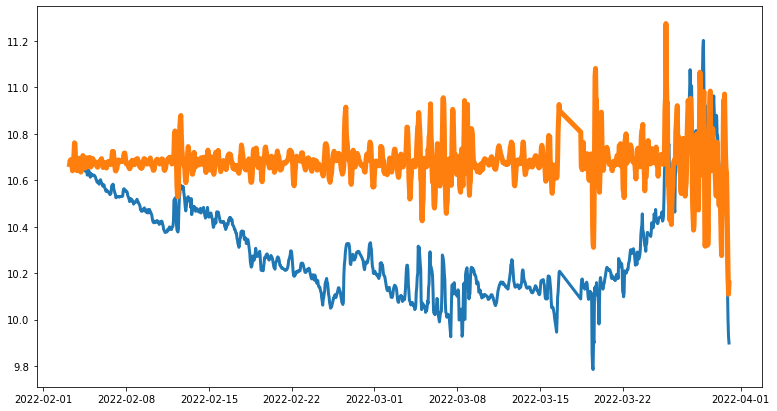

In [20]:
fig, ax = plt.subplots(1, figsize=(13, 7))
ax.plot(targets, label='actual', linewidth=3)
ax.plot(preds, label='prediction', linewidth=5)

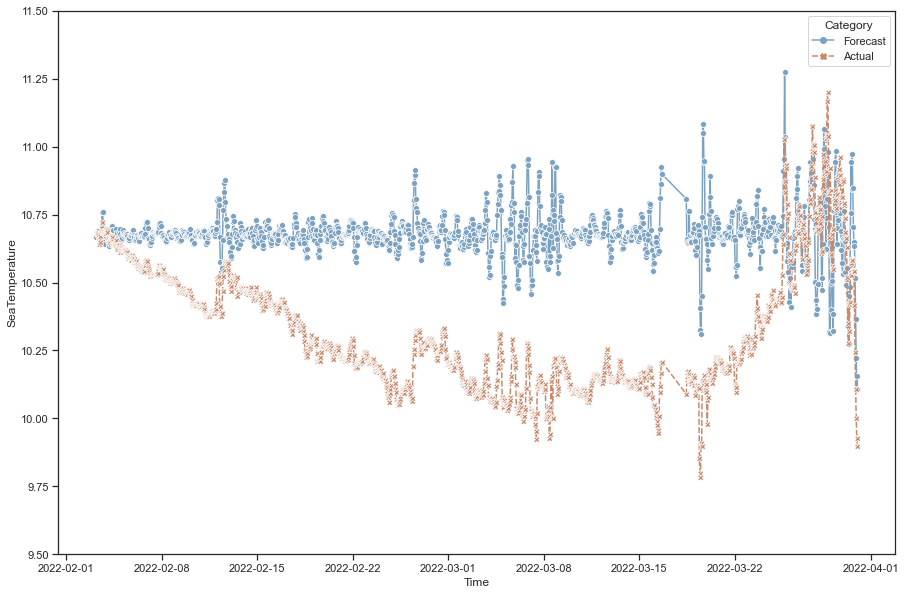

In [71]:
import seaborn as sns
fig, ax = plt.subplots(1, figsize=(15, 10))
sns.set_theme(style="ticks")

actuals = pd.DataFrame({'Time':targets.index, 'SeaTemperature':targets.values, 'Category':['Actual']*targets.count()})
forecast = pd.DataFrame({'Time':preds.index, 'SeaTemperature':preds.values, 'Category':['Forecast']*preds.count()})
# actuals = pd.DataFrame(targets)
# actuals.rename(columns={0:'actual'},inplace=True)
# predictions = pd.DataFrame(preds)
# predictions.rename(columns={0:'prediction'},inplace=True)
blah = pd.concat([forecast, actuals])
blah['year'] = blah['Time'].dt.year
blah['month'] = blah['Time'].dt.month
ax.set(ylim=(9.5, 11.5))
ax = sns.lineplot(data=blah, x="Time", y="SeaTemperature", style='Category', palette = 'twilight_shifted', hue='Category', markers=True, dashes=True)
# blah
l1 = ax.lines[0]
l2 = ax.lines[1]

# Get the xy data from the lines so that we can shade
# x1 = l1.get_xydata()[:,0]
# y1 = l1.get_xydata()[:,1]
# x2 = l2.get_xydata()[:,0]
# y2 = l2.get_xydata()[:,1]
# ax.fill_between(x1,y1, color="red", alpha=0.3)
# ax.fill_between(x2,y2, color="blue", alpha=0.3)

plt.show(block=True)

<Figure size 2160x1800 with 0 Axes>

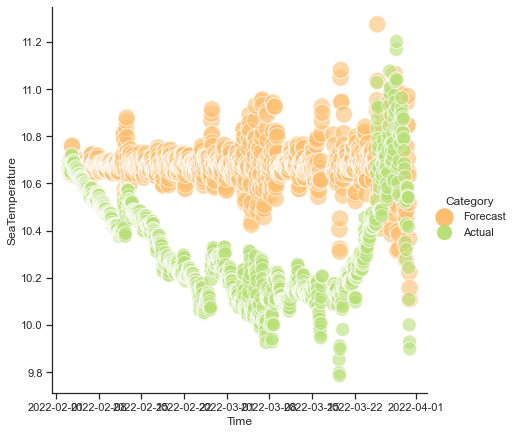

In [22]:
plt.figure(figsize=(30,25))
sns.set_theme(style="ticks")
sns.relplot(x="Time", y="SeaTemperature", hue="Category", size="Category",
            sizes=(200, 300), alpha=.6, palette="RdYlGn",
            height=6, data=blah)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [24]:
# np.random.seed(42)
# window_len = 5
# test_size = 0.2
# zero_base = True
# lstm_neurons = 100
# epochs = 20
# batch_size = 32
# loss = 'mse'
# dropout = 0.2
# optimizer = 'adam'

In [25]:
# train, test, X_train, X_test, y_train, y_test = prepare_data(
#     hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [26]:
# model = build_lstm_model(
#     X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
#     optimizer=optimizer)
# history = model.fit(
#     X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

In [27]:
# preds = test[target_col].values[:-window_len] * (preds + 1)
# preds = pd.Series(index=targets.index, data=preds)
# line_plot(targets, preds, 'actual', 'prediction', lw=3)